<a href="https://colab.research.google.com/github/IT22306586/DL-LAB7-Part2/blob/master/Deep_Q_Learning_GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class GridWorld:
    def __init__(self):
        self.height = 20
        self.width = 20
        self.grid = np.zeros((self.height, self.width)) - 1

        self.current_location = (4, np.random.randint(0,5))
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def reset(self):
        self.current_location = (4, np.random.randint(0,5))
        return self.current_location

    def get_available_actions(self):
        return self.actions

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0]-1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0]+1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1]-1)
                reward = self.get_reward(self.current_location)
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1]+1)
                reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        return 'NON-TERMINAL'


In [ ]:
class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)


In [ ]:
def one_hot_state(env, state):
    s = np.zeros(env.height * env.width, dtype=np.float32)
    s[state[0] * env.width + state[1]] = 1.0
    return s

In [ ]:
def train_DQN(env, episodes=300, gamma=0.95, lr=0.001, epsilon=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dim = env.height * env.width
    action_dim = len(env.actions)
    model = DQNNet(state_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    rewards_per_episode = []

    for ep in range(episodes):
        state = env.reset()
        s_vec = one_hot_state(env, state)
        done = False
        total_reward = 0

        while not done:
            if random.random() < epsilon:
                action = random.choice(range(action_dim))
            else:
                with torch.no_grad():
                    q_vals = model(torch.tensor(s_vec).to(device))
                    action = int(torch.argmax(q_vals).item())

            next_state, reward = None, env.make_step(env.actions[action])
            done = env.check_state() == 'TERMINAL'
            next_vec = one_hot_state(env, env.current_location)

            with torch.no_grad():
                q_next = model(torch.tensor(next_vec, dtype=torch.float32).to(device))
                q_target = torch.tensor([reward], dtype=torch.float32).to(device)
                if not done:
                    q_target += gamma * torch.max(q_next)

            q_pred = model(torch.tensor(s_vec, dtype=torch.float32).to(device))[action]

            # Make sure q_pred is also a single value tensor
            loss = loss_fn(q_pred.unsqueeze(0), q_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reward += reward
            s_vec = next_vec

        rewards_per_episode.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995)

        if ep % 50 == 0:
            print(f"Episode {ep}, Total Reward: {total_reward:.2f}")

    return rewards_per_episode

In [ ]:
env = GridWorld()
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"\nTraining with epsilon = {eps}")
    rewards = train_DQN(env, episodes=300, epsilon=eps)
    results[eps] = rewards


Training with epsilon = 0.1
Episode 0, Total Reward: -6.00
Episode 50, Total Reward: 4.00
Episode 100, Total Reward: 4.00
Episode 150, Total Reward: 4.00
Episode 200, Total Reward: 3.00
Episode 250, Total Reward: 2.00

Training with epsilon = 0.5
Episode 0, Total Reward: -117.00
Episode 50, Total Reward: -28.00
Episode 100, Total Reward: 5.00
Episode 150, Total Reward: -5.00
Episode 200, Total Reward: 5.00
Episode 250, Total Reward: 5.00

Training with epsilon = 0.9
Episode 0, Total Reward: -41.00
Episode 50, Total Reward: -41.00
Episode 100, Total Reward: -13.00
Episode 150, Total Reward: -1.00
Episode 200, Total Reward: -9.00
Episode 250, Total Reward: -2.00


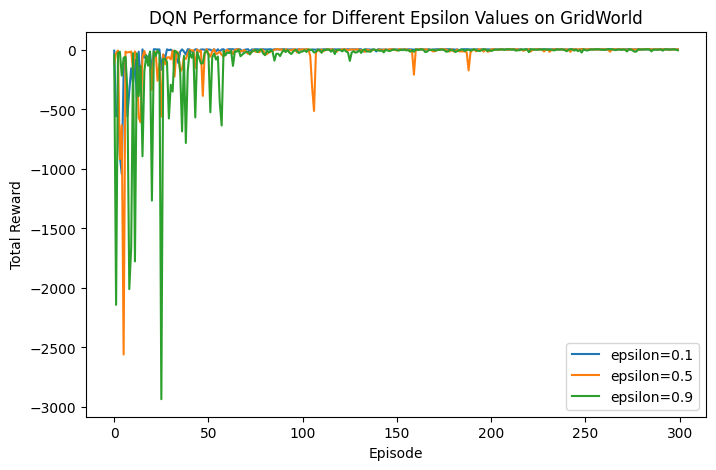

In [ ]:
plt.figure(figsize=(8,5))
for eps, rewards in results.items():
    plt.plot(rewards, label=f"epsilon={eps}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("DQN Performance for Different Epsilon Values on GridWorld")
plt.show()

Observation -

0.1-
Agent explores very little, learns stable policy quickly but may miss better paths. And fast covergence

0.5-
This gives a good balance, stable learning and better final policy.

0.9-
Learns slower because it explores too much, but eventually reaches high performance.